- - - -
# LED Electrical Characteristics

- - - -

Troy Messina @ Berea College

- - - -

**1) Load Current-Voltage (I-V) Data**    
**2) Plot Data**  
**3) Curve Fitting**  

- - - -

This is a smattering of scripts to work with data collected from ELVISmx and myDAQ.

In [4]:
# import modules
import pandas as pd
import numpy as np
from numpy import array, arange, pi, exp, sin, cos, polyfit, poly1d, linspace, zeros, flipud
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import fmin
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

                     time[0]       Ch0                 time[1]       Ch1
0    2018-09-04 15:20:29.839  2.598231 2018-09-04 15:20:29.839  2.632453
1    2018-09-04 15:20:29.839  2.594972 2018-09-04 15:20:29.839  2.626912
2    2018-09-04 15:20:29.840  2.592690 2018-09-04 15:20:29.840  2.622023
3    2018-09-04 15:20:29.840  2.589757 2018-09-04 15:20:29.840  2.618112
4    2018-09-04 15:20:29.841  2.586172 2018-09-04 15:20:29.841  2.613223
5    2018-09-04 15:20:29.841  2.583564 2018-09-04 15:20:29.841  2.607683
6    2018-09-04 15:20:29.842  2.580957 2018-09-04 15:20:29.842  2.603772
7    2018-09-04 15:20:29.842  2.577698 2018-09-04 15:20:29.842  2.598557
8    2018-09-04 15:20:29.843  2.575090 2018-09-04 15:20:29.843  2.593668
9    2018-09-04 15:20:29.843  2.571505 2018-09-04 15:20:29.843  2.588127
10   2018-09-04 15:20:29.844  2.568572 2018-09-04 15:20:29.844  2.584216
11   2018-09-04 15:20:29.844  2.564987 2018-09-04 15:20:29.844  2.578675
12   2018-09-04 15:20:29.845  2.561076 2018-09-04 1

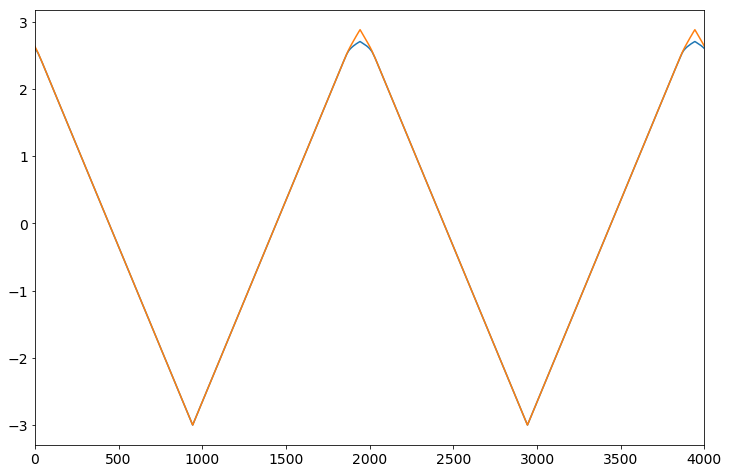

In [5]:
#We'll use pandas to load an Excel file. Pandas is very smart at this.
df = pd.read_excel('/home/nbuser/library/LED100Ohmdata.xlsx', 'LED100Ohmdata', index_col=None, na_values=['NA'])
print(df) #Print what gets read. We'll see that the columns are labeled, and we can call by these labels.
df['Ch0'].plot() #Plot the data labeled Ch0. This is our LED Voltage.
df['Ch1'].plot() #Add to the plot the data labeled Ch1. This is our input Voltage.
plt.show()

Okay, we have data, and it plots just like what our oscilloscope screen looked like. Since we know the period is 1 second from our settings on the function generator, we could scale the plot above, but we don't care about time. What we care about is the current in the circuit at particular LED Voltage drops. So, we need to do some math to calculate current. We have a two element series circuit. This means there is one value of current flowing through the circuit.

$$V_{in} = V_R + V_{LED}$$

$$V_{in} = I R + V_{LED}$$

$$I = \frac{V_{in}-V_{LED}}{R}$$


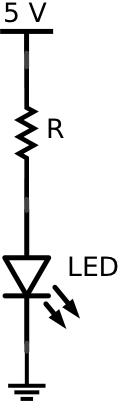



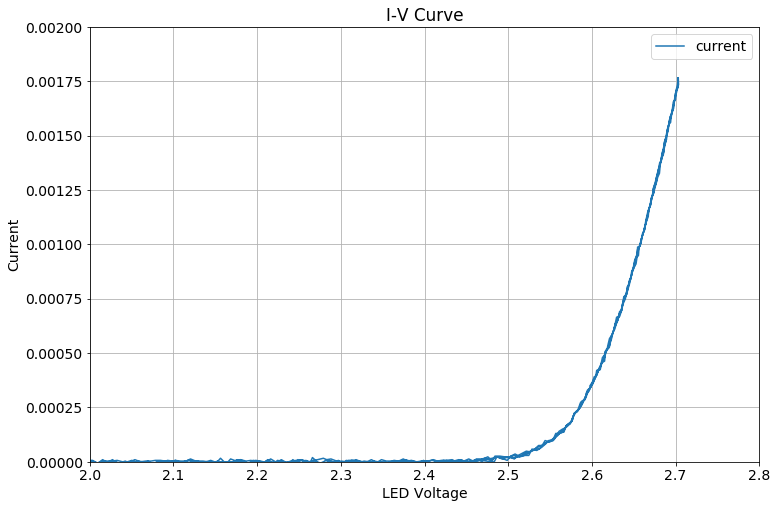

In [6]:
#current = (df.Ch1-df.Ch0)/100
df['current'] = (df['Ch1']-df['Ch0'])/100 #Calculate the current as derived above and put it in the dataframe created by Pandas.
df.plot(x='Ch0', y='current') #Plot current vs. LED Voltage
plt.xlabel('LED Voltage')
plt.ylabel('Current')
plt.title('I-V Curve')
plt.axis([2, 2.8, 0, 0.002])
plt.grid(True)
plt.show()

### Let's dump the data from a pandas dataframe into a numpy array.
Our data is in a dataframe that pandas created. It might be simpler to deal with individual arrays containing our current and LED voltage data. We'll copy the relevant dataframe data into these arrays.

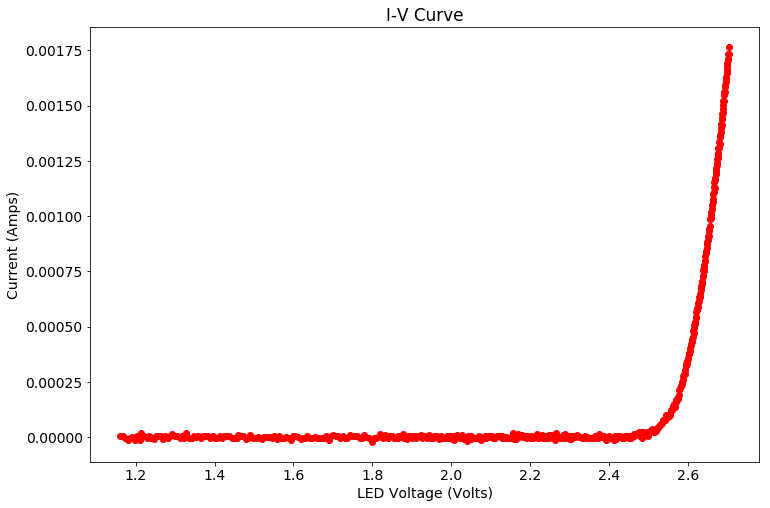

In [9]:
datamatrix = df.values
LEDVoltage = np.array(datamatrix[1750:2250,1], dtype=np.float64)
InputVoltage = np.array(datamatrix[1750:2250,3], dtype=np.float64)
LEDCurrent = np.array(datamatrix[1750:2250,4], dtype=np.float64)
plt.plot(LEDVoltage, LEDCurrent, 'ro')
plt.xlabel('LED Voltage (Volts)')
plt.ylabel('Current (Amps)')
plt.title('I-V Curve')
plt.show()

## Non-linear least squares using fmin optimization
Now that our data is in arrays, we can use SciPy to do some curve fitting. The fit function is known as the Shockley diode equation.

$$I = I_s \left(e^{\frac{qV}{Nk_BT}} - 1\right)$$

The function is described below.

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 66
         Function evaluations: 121
values of the fitting parameters
[26.36614601  2.58623492]


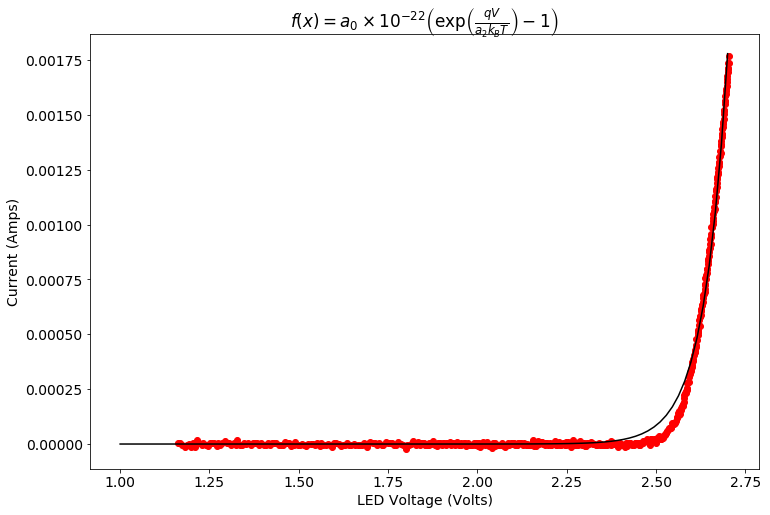

In [11]:
# non-linear least squares
#x = arange(-pi,pi, 0.01)
#constants
kB = 1.381e-23
q = 1.602e-19
T = 295
mult = 1e-22

X = LEDVoltage
Y = LEDCurrent

fn = lambda a: a[0]*mult*(exp(X*(q/kB/T)/a[1])-1)

## minimize the squares of the deviations
Sn = lambda x: sum( (fn(x)-Y)**2 )
A = fmin(func=Sn, x0=[24,2.5])

print('values of the fitting parameters')
print(A)

plt.plot(X, Y,'ro')
xplot = linspace(1,2.7,100)
fnfit = lambda x,a: (a[0]*mult*(exp(x*(q/kB/T)/a[1])-1))
plt.plot(xplot, fnfit(xplot, A), 'k')
plt.title(r'$f(x)=a_0 \times 10^{-22} \left( \exp \left(\frac{qV}{a_2k_B T}\right)-1\right)$')
plt.xlabel('LED Voltage (Volts)')
plt.ylabel('Current (Amps)')
#plt.xlim([1,2.8])
#plt.ylim([-0.0001,0.0018])
plt.show()

## Another example with curve_fit optimization for curve fitting

values of the fitting parameters
[26.36699281  2.58623696]
[[6.30642927e+01 1.52045016e-01]
 [1.52045016e-01 3.66611339e-04]]


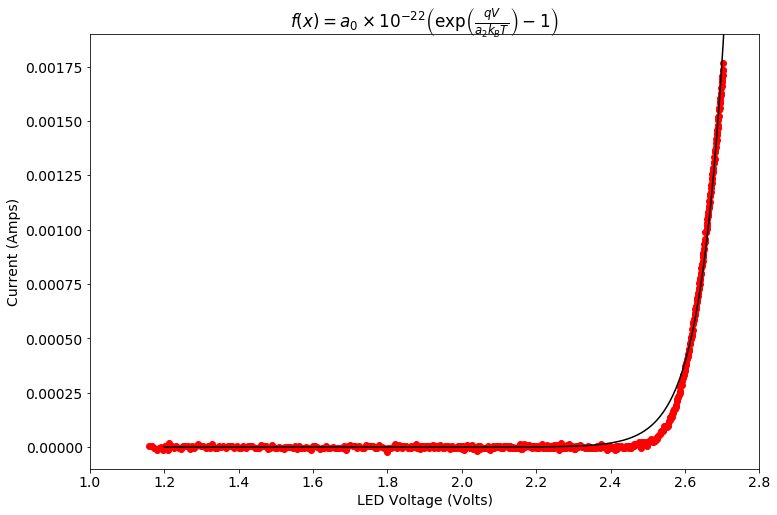

In [34]:
# curve_fit optization
def f(x, a, b):
    return a*mult*(exp(x*q/kB/T/b)-1)

a = 1
b = 2
xx = linspace(1.2, 2.88, 200)
popt, pcov = curve_fit(f, X, Y, (a,b))

print('values of the fitting parameters')
print(popt)
print(pcov)

plt.plot(X, Y,'ro')
plt.plot(xx, f(xx, *popt), 'k')
plt.title(r'$f(x)=a_0 \times 10^{-22} \left( \exp \left(\frac{qV}{a_2k_B T}\right)-1\right)$')
plt.xlim([1,2.8])
plt.ylim([-0.0001,0.0019])
plt.xlabel('LED Voltage (Volts)')
plt.ylabel('Current (Amps)')
plt.show()

## Making Sense of the fit parameters.
The first parameter tells us something about the current. It is called the reverse bias saturation current, $I_s$ It will be the value of current in some limit. **What do you think this limit might be?** Under reverse bias (when the n side is put at a more positive voltage than the p side) the exponential term in the diode equation is near zero and the current is near a constant (negative) reverse current value of $−I_S$. **Show a sample calculation to prove to yourself this is true.** The reverse breakdown region is not modeled by the Shockley diode equation.

The second parameter tells us about the relationship between LED input energy ($qV$) and the thermal energy $k_BT$. In an ideal diode, the function should have this parameter equal to one ($N=1$). Since no diode is ideal this value will be a positive number that is one or greater. It typically falls in the range $1 \le N \le 3$.

If we plot the resistor current vs. LED voltage ($V_{LED}$), it should be a straight line with a negative slope. **Why is the slope negative?** Let's look at this mathematically.

$$I = \frac{V_{in}^{max} - V_{LED}}{R}$$

Let's choose a particular input voltage of 2.88 V.

$$ I = \frac{2.88 - V_{LED}}{R}$$

$$ I = 0.0288 - \frac{V_{LED}}{R}$$

$$ I = - \frac{V_{LED}}{R} + 0.0288$$

This is an equation of a line that we can plot on our graph. We could choose any input voltage and re-solve the line, but the input voltage we choose needs to be equal to the largest input voltage. The crossing between this line and the LED current vs. voltage is the point where the LED is considered to turn on.

2.879829


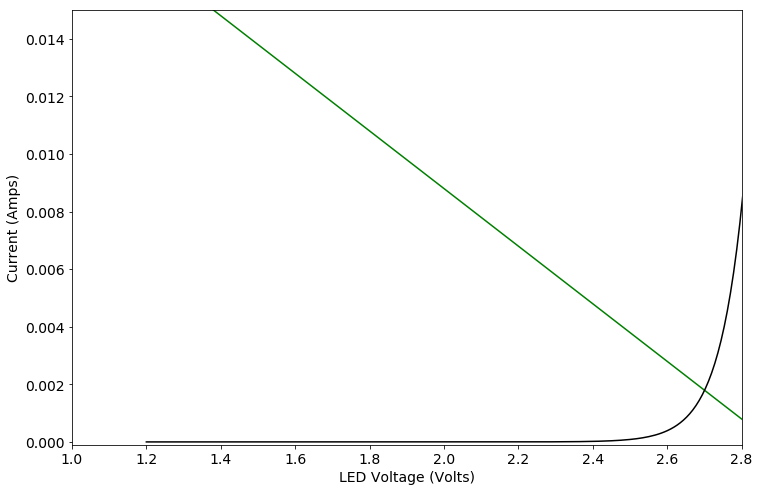

In [45]:
Vdmax = np.amax(InputVoltage)
print(Vdmax)
VR = xx
VR = (Vdmax - xx)/100
plt.plot(xx, VR,'g')
plt.plot(xx, f(xx, *popt), 'k')
#plt.title(r'$f(x)=a_0 \times 10^{-22} \left( \exp \left(\frac{qV}{a_2k_B T}\right)-1\right)$')
plt.xlim([1,2.8])
plt.ylim([-0.0001,0.015])
plt.xlabel('LED Voltage (Volts)')
plt.ylabel('Current (Amps)')
plt.show()